In [29]:
from gensim.models import Word2Vec
import os
import json
import datetime
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

In [30]:
DATA = "../data/data"

In [31]:
total_playlists = 0
total_tracks = 0
uri_to_track = {}
tokens = []
tracks = set()
artists = set()
albums = set()
titles = set()
total_descriptions = 0
ntitles = set()

In [32]:
def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            for playlist in mpd_slice["playlists"]:
                process_playlist(playlist)
            count += 1

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

def to_date(epoch):
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d")

def process_playlist(playlist):
    global total_playlists, total_tracks, tokens

    total_playlists += 1

    titles.add(playlist["name"])
    nname = normalize_name(playlist["name"])
    ntitles.add(nname)

    tracks = playlist["tracks"]
    total_tracks += len(tracks)
    curr_tokens = [track["track_uri"] for track in tracks]
    for track in tracks:
        uri = track["track_uri"]
        if uri not in uri_to_track:
            uri_to_track[uri] = track

    tokens.append(curr_tokens)

In [33]:
process_mpd(DATA)

In [34]:
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

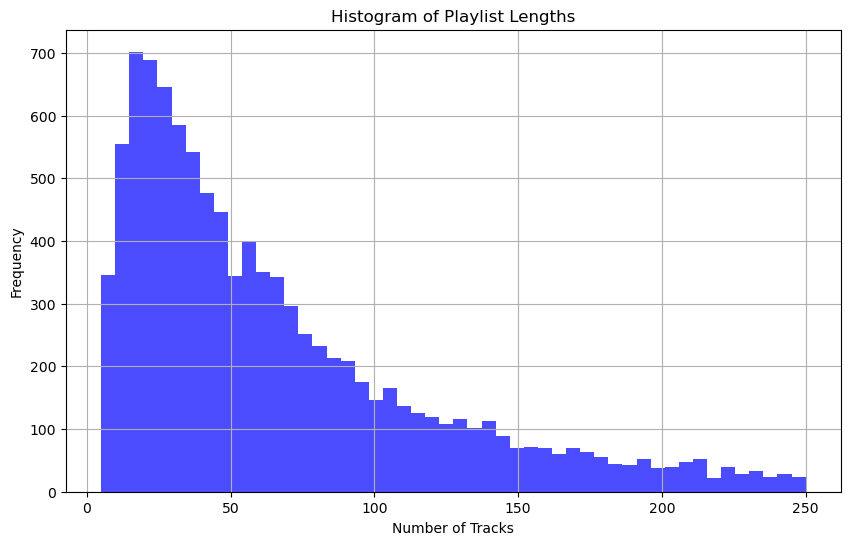

In [35]:
# plot histogram of length of tokens
plot_histogram(
    [len(t) for t in tokens],
    "Histogram of Playlist Lengths",
    "Number of Tracks",
    "Frequency"
)

In [36]:
def filter_rare_tokens(playlists, min_count=5):
    all_tokens = []
    for playlist in playlists:
        for token in playlist:
            all_tokens.append(token)

    token_counts = Counter(all_tokens)

    return [
        [token for token in pl if token_counts[token] >= min_count]
        for pl in playlists
        # TODO: magic number
        if len(pl) >= 10  # remove playlists that become too short
    ]

In [37]:
filtered_tokens = filter_rare_tokens(tokens, min_count=5)

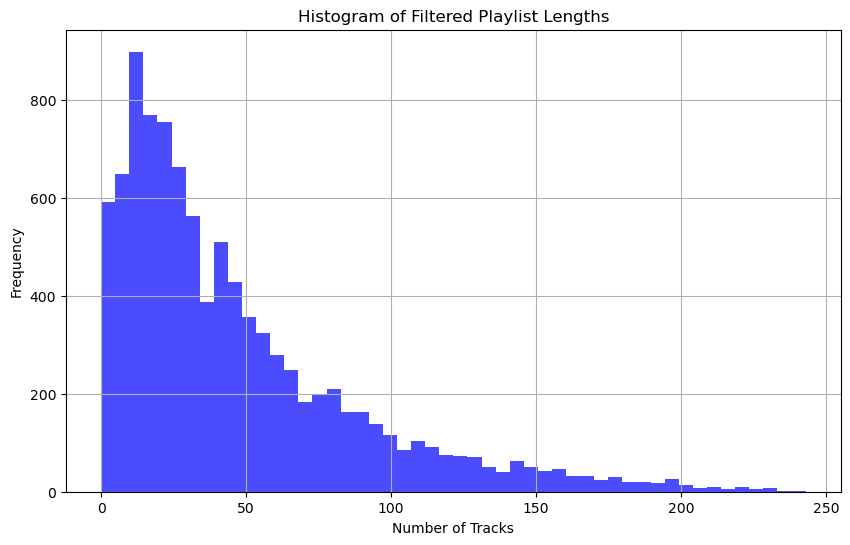

In [38]:
plot_histogram(
    [len(t) for t in filtered_tokens],
    "Histogram of Filtered Playlist Lengths",
    "Number of Tracks",
    "Frequency"
)

In [39]:
model = Word2Vec(
    sentences=filtered_tokens,
    vector_size=128,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # skip-gram
)

In [40]:
model.save("word2vec.model")

In [41]:
for wv in model.wv.index_to_key[:10]:
    track = uri_to_track.get(wv, None)
    track_name = track["track_name"] if track else "Unknown Track"
    track_artist = track["artist_name"] if track else "Unknown Artist"
    track_album = track["album_name"] if track else "Unknown Album"

    for curr in model.wv.most_similar(wv, topn=10):
        curr_track = uri_to_track.get(curr[0], None)
        curr_name = curr_track["track_name"] if curr_track else "Unknown Track"
        curr_artist = curr_track["artist_name"] if curr_track else "Unknown Artist"
        curr_album = curr_track["album_name"] if curr_track else "Unknown Album"

        print(f"{track_name} by {track_artist} ({track_album}) "
              f"similar to {curr_name} by {curr_artist} ({curr_album}) "
              f"with similarity {curr[1]:.4f}")

HUMBLE. by Kendrick Lamar (DAMN.) similar to DNA. by Kendrick Lamar (DAMN.) with similarity 0.9700
HUMBLE. by Kendrick Lamar (DAMN.) similar to Mask Off by Future (FUTURE) with similarity 0.9601
HUMBLE. by Kendrick Lamar (DAMN.) similar to XO TOUR Llif3 by Lil Uzi Vert (Luv Is Rage 2) with similarity 0.9495
HUMBLE. by Kendrick Lamar (DAMN.) similar to Passionfruit by Drake (More Life) with similarity 0.9486
HUMBLE. by Kendrick Lamar (DAMN.) similar to goosebumps by Travis Scott (Birds In The Trap Sing McKnight) with similarity 0.9444
HUMBLE. by Kendrick Lamar (DAMN.) similar to Congratulations by Post Malone (Stoney) with similarity 0.9424
HUMBLE. by Kendrick Lamar (DAMN.) similar to Dan Bilzerian by T-Pain (Dan Bilzerian) with similarity 0.9395
HUMBLE. by Kendrick Lamar (DAMN.) similar to Look At Me! by XXXTENTACION (Look At Me!) with similarity 0.9336
HUMBLE. by Kendrick Lamar (DAMN.) similar to LOYALTY. FEAT. RIHANNA. by Kendrick Lamar (DAMN.) with similarity 0.9309
HUMBLE. by Kendr

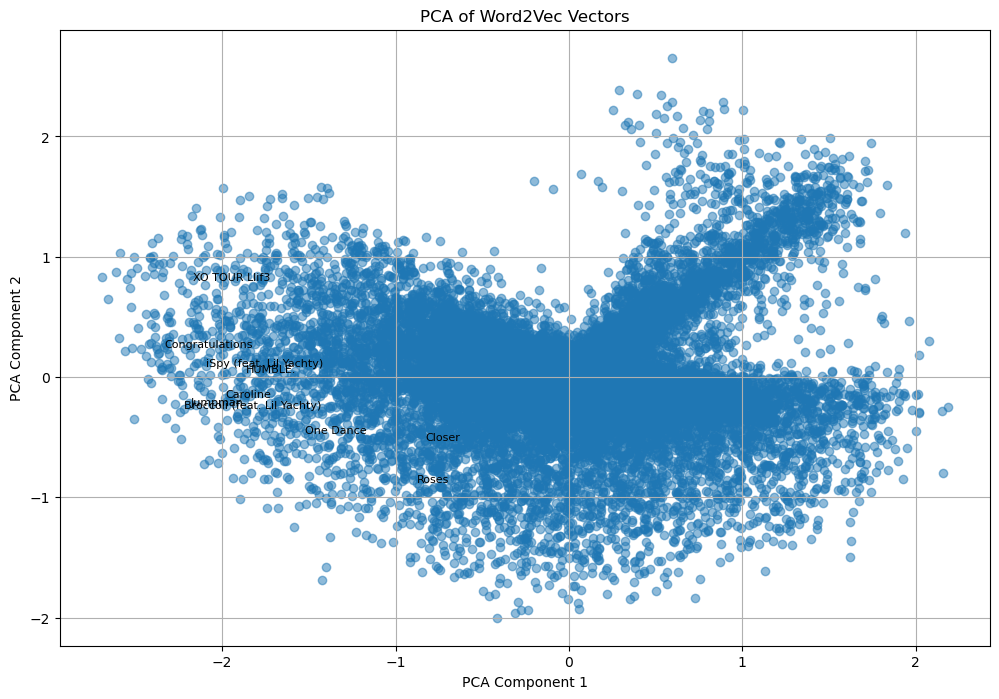

In [46]:
# PCA analysis of vectors

def plot_pca(model):
    pca = PCA(n_components=2)
    vectors = model.wv.vectors
    reduced_vectors = pca.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)

    for i, word in enumerate(model.wv.index_to_key[:10]):  # limit to first 100 words for clarity
        track_name = uri_to_track.get(word, {}).get("track_name", "Unknown Track")
        plt.annotate(track_name, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

    plt.title("PCA of Word2Vec Vectors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

plot_pca(model)

Text(0.5, 1.0, 't-SNE of Word2Vec Vectors')

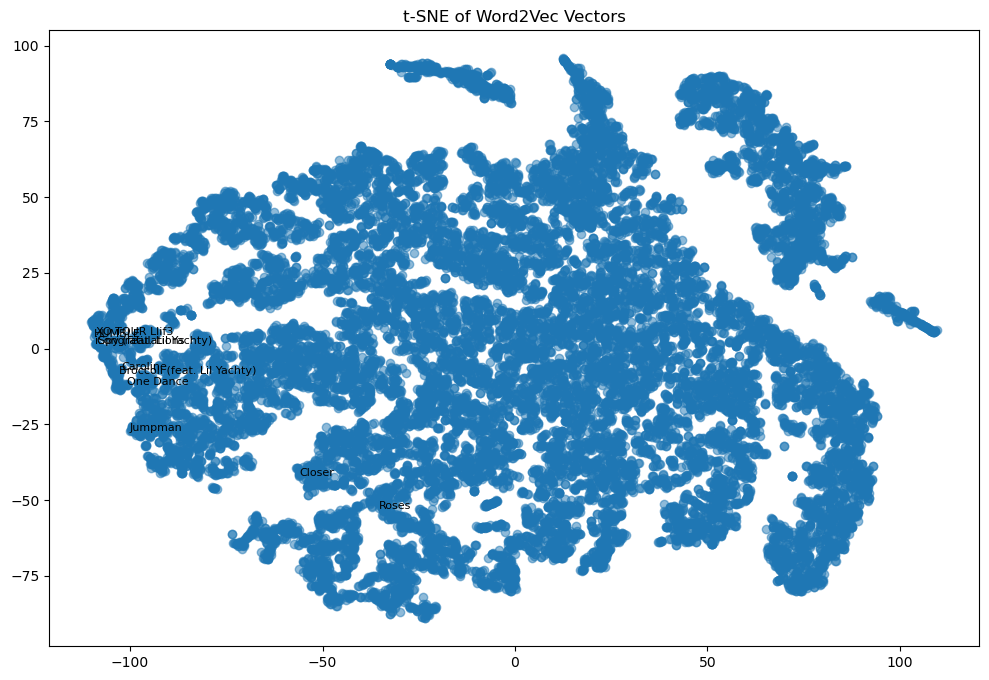

In [48]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
vectors = model.wv.vectors
coords = tsne.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
for i, word in enumerate(model.wv.index_to_key[:10]):  # limit to first 100 words for clarity
    track_name = uri_to_track.get(word, {}).get("track_name", "Unknown Track")
    plt.annotate(track_name, (coords[i, 0], coords[i, 1]), fontsize=8)
plt.title("t-SNE of Word2Vec Vectors")